# Hands-On: Time Series Analysis (Physics) — 1.5h

**Topics:** Autocorrelation, ARIMA, Fourier, Wavelets  
**Dataset:** Monthly Sunspot Numbers (astronomy/solar physics; bundled with `statsmodels`).  
**Goal:** Apply core time-series tools to a real physics time series and interpret results like a physicist (oscillations, periodicities, prediction).



## Learning outcomes
By the end, you should be able to:
- Load a physics time series and get it into a tidy format.
- Inspect autocorrelation structures and reason about stationarity.
- Fit and diagnose an **ARIMA** model for short-term forecasting.
- Use **FFT** to estimate dominant periodicities (power spectrum).
- Use **wavelets** to reveal **time-varying** periodic content.

## Environment & Setup
This notebook requires:
- Python ≥ 3.9
- `numpy`, `pandas`, `matplotlib`, `scipy`, `statsmodels`, `pywt` (PyWavelets)

> If `pywt` is not available, the code will fall back to a Morlet-based CWT via `scipy.signal.cwt`.

## 1) Load Physics Data: Monthly Sunspot Numbers
**Why sunspots?** They are a classic physics/astronomy time series with known ~11-year cycles.  
We use the dataset bundled with `statsmodels` : sm.datasets.sunspots.load_pandas()

In [3]:

# Load monthly sunspot data (built-in, 1700–2008)
sun = sm.datasets.sunspots.load_pandas().data
sun.head()

,YEAR,SUNACTIVITY
0,1700.0,5.0
1,1701.0,11.0
2,1702.0,16.0
3,1703.0,23.0
4,1704.0,36.0


In [4]:

# Make a proper datetime index and tidy series
sun['YEAR'] = sun['YEAR'].astype(int)
# The dataset has 'SUNACTIVITY' per **year**, but there's also a monthly version in statsmodels.
# We'll instead use the **monthly** sunspots dataset: 'sm.tsa.datasets.sunspots' (deprecated in some versions).
# Robust path: use the classic yearly first, then try to fetch monthly if available.

try:
    # Some statsmodels versions expose monthly sunspots here:
    from statsmodels.datasets import sunspots as sm_sun_monthly
    sun_m = sm_sun_monthly.load_pandas().data.copy()
    # Columns often include 'YEAR' and 'SUNACTIVITY'; monthly sometimes includes 'MONTH'
    if 'MONTH' in sun_m.columns:
        sun_m['MONTH'] = sun_m['MONTH'].astype(int)
        sun_m['DATE'] = pd.to_datetime(dict(year=sun_m['YEAR'].astype(int),
                                           month=sun_m['MONTH'].astype(int),
                                           day=1))
        ts = pd.Series(sun_m['SUNACTIVITY'].values, index=sun_m['DATE']).sort_index()
    else:
        # Fallback: construct a monthly index from year fractions if present
        if 'PERIOD' in sun_m.columns:
            # PERIOD might be fractional year; convert to datetime approx by month
            years = sun_m['YEAR'].astype(int)
            months = ((sun_m['PERIOD'] - np.floor(sun_m['PERIOD'])) * 12 + 1).round().astype(int).clip(1,12)
            sun_m['DATE'] = pd.to_datetime(dict(year=years, month=months, day=1))
            ts = pd.Series(sun_m['SUNACTIVITY'].values, index=sun_m['DATE']).sort_index()
        else:
            # As last resort, stick to yearly
            ts = pd.Series(sun['SUNACTIVITY'].values, index=pd.to_datetime(sun['YEAR'], format='%Y'))
except Exception:
    # Fall back to yearly data only
    ts = pd.Series(sun['SUNACTIVITY'].values, index=pd.to_datetime(sun['YEAR'], format='%Y'))

ts = ts.asfreq('MS') if ts.index.inferred_type in ('datetime64', 'datetime') else ts
ts = ts.dropna()
ts.name = 'sunspots'
ts.head()

,sunspots
YEAR,
1700-01-01,5.0
1701-01-01,11.0
1702-01-01,16.0
1703-01-01,23.0
1704-01-01,36.0


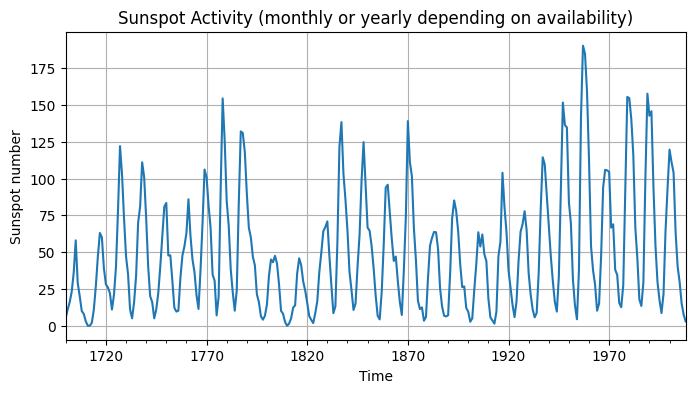

In [6]:

# Quick visualization
ax = ts.plot(title='Sunspot Activity (monthly or yearly depending on availability)')
ax.set_xlabel('Time')
ax.set_ylabel('Sunspot number')
plt.show()

### Task 1.1 — Basic Exploration
1. Compute summary stats: mean, std, min, max.  
2. Plot a rolling mean and rolling std (window=24 months if monthly, or window=5 if yearly).  
3. Comment: do you see long-term cycles?

## 2) Autocorrelation & Stationarity
Examine the **autocorrelation function (ACF)** and **partial autocorrelation (PACF)**.  
Run an **ADF test** (Augmented Dickey–Fuller) to gauge stationarity.

### Task 2.1 — Differencing (if needed)
If the series looks non-stationary, difference it (e.g., `ts.diff().dropna()` or seasonal diff `ts.diff(12)`) and repeat ACF/PACF & ADF.  
**Question:** What differencing makes it *most* stationary without over-differencing?

## 3) ARIMA Modeling


### Task 3.1 — Choose an ARIMA (or seasonal ARIMA) based on ACF/PACF cues and iterate quickly.  
**Tip:** Start simple (ARIMA(p, d, q)), then try seasonal (SARIMA) if strong seasonality is present (monthly → possibly `m=12`).

### Task 3.2 — Seasonal ARIMA (Optional if time)
If `MS` (monthly) data is available: try a small seasonal model, e.g. `SARIMA(p, d, q) x (P, D, Q, 12)`.

## 4) Fourier Analysis (FFT)
Compute the **power spectrum** via FFT to identify dominant periodicities (e.g., the ~11-year sunspot cycle).  
We convert to zero-mean, apply a window, compute FFT magnitude, and plot vs. frequency.

### Task 4.1 — Windowing & Detrending
Try different windows (`np.hanning`, `np.hamming`) and detrending (remove linear trend using `signal.detrend`).  
**Question:** How sensitive is the dominant period to preprocessing?

## 5) Wavelet Analysis
Wavelets show **how** dominant periods evolve over time.  
We use the **Morlet** wavelet via PyWavelets (`cwt`) if available; otherwise use SciPy's `signal.cwt`.

### Task 5.1 — Interpret time-localized periodicities
- Identify bands/scales of strong power.
- Do you see changes in periodicity strength over time? How does this compare to the FFT results?

## 6) Wrap-up (Short Reflection)
- What does ACF/PACF tell you about memory and seasonality?
- Compare ARIMA forecasts with physical expectations (e.g., cycle phases).
- How do FFT vs. Wavelets complement each other?
- If you had **no stationarity**, which tool(s) would you trust more and why?